## k-Nearest Neighbor (kNN) Test on The Zen Performer
The kNN classifier consists of two stages(CS231N Course Framework):
- Training Stage: the classifier takes the training data and simply remembers it
- Testing Stage: kNN classifies every test image by comparing to all training images and transfering the labels of the k most similar clusters
- The value of k is cross-validated

In [1]:
# Setup code for the notebook.

import random
import numpy as np
from cs231n.data_utils import load_CIFAR10
import matplotlib.pyplot as plt

# To make matplotlib figures appear inline in the notebook

%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

# Notebook will reload external python modules

%load_ext autoreload
%autoreload 2

In [2]:
# Load the raw CIFAR-10 data.
cifar10_dir = 'cs231n/datasets/cifar-10-batches-py'

# Cleaning up variables to prevent loading data multiple times (which may cause memory issue)
try:
   del X_train, y_train
   del X_test, y_test
   print('Clear previously loaded data.')
except:
   pass

X_train, y_train, X_test, y_test = load_CIFAR10(cifar10_dir)

# As a sanity check, we print out the size of the training and test data.
print('Training data shape: ', X_train.shape)
print('Training labels shape: ', y_train.shape)
print('Test data shape: ', X_test.shape)
print('Test labels shape: ', y_test.shape)

Training data shape:  (50000, 32, 32, 3)
Training labels shape:  (50000,)
Test data shape:  (10000, 32, 32, 3)
Test labels shape:  (10000,)


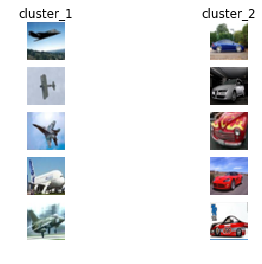

In [3]:
# Visualize some examples from the dataset.
# Few examples of training images from each cluster.
classes = ['cluster_1','cluster_2']
num_classes = len(classes)
samples_per_class = 5
for y, cls in enumerate(classes):
    idxs = np.flatnonzero(y_train == y)
    idxs = np.random.choice(idxs, samples_per_class, replace=False)
    for i, idx in enumerate(idxs):
        plt_idx = i * num_classes + y + 1
        plt.subplot(samples_per_class, num_classes, plt_idx)
        plt.imshow(X_train[idx].astype('uint8'))
        plt.axis('off')
        if i == 0:
            plt.title(cls)
plt.show()

In [4]:
# Sample for Data Specification
num_training = 5000
mask = list(range(num_training))
X_train = X_train[mask]
y_train = y_train[mask]

num_test = 500
mask = list(range(num_test))
X_test = X_test[mask]
y_test = y_test[mask]

# Image reshaping
X_train = np.reshape(X_train, (X_train.shape[0], -1))
X_test = np.reshape(X_test, (X_test.shape[0], -1))
print(X_train.shape, X_test.shape)

(5000, 3072) (500, 3072)


In [5]:
from cs231n.classifiers import KNearestNeighbor

# kNN classifier instance creation 
# Data collection from the classifier
classifier = KNearestNeighbor()
classifier.train(X_train, y_train)

Data classification with the kNN classifier into two steps: 

1. Distances computation between all test examples and all train examples. 
2. Detection of the k nearest images based on computed examples and then label selection

In [6]:
# Open cs231n/classifiers/k_nearest_neighbor.py and implement
# compute_distances_two_loops.

# Test your implementation:
dists = classifier.compute_distances_two_loops(X_test)
print(dists.shape)

(500, 5000)


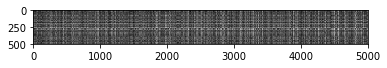

In [7]:
# We can visualize the distance matrix: each row is a single test example and
# its distances to training examples
plt.imshow(dists, interpolation='none')
plt.show()

In [8]:
# Now implement the function predict_labels and run the code below with k = 2:

y_test_pred = classifier.predict_labels(dists, k=2)

# Compute and print the fraction of correctly predicted examples

num_correct = np.sum(y_test_pred == y_test)
accuracy = float(num_correct) / num_test
print('Got %d / %d correct => accuracy: %f' % (num_correct, num_test, accuracy))



Got 120 / 500 correct => accuracy: 0.240000


In [9]:
# Fully vectorized version inside compute_distances_no_loops

dists_two = classifier.compute_distances_no_loops(X_test)

# check that the distance matrix agrees with the one we computed before:
difference = np.linalg.norm(dists - dists_two, ord='fro')
print('No loop difference was: %f' % (difference, ))
if difference < 0.03:
    print('Good! The distance matrices are the same')
else:
    print('Uh-oh! The distance matrices are different')

No loop difference was: 0.000000
Good! The distance matrices are the same


In [10]:
# Let's compare how fast the implementations are
def time_function(f, *args):
    """
    Call a function f with args and return the time (in seconds) that it took to execute.
    """
    import time
    tic = time.time()
    f(*args)
    toc = time.time()
    return toc - tic

no_loop_time = time_function(classifier.compute_distances_no_loops, X_test)
print('No loop version took %f seconds' % no_loop_time)

# You should see significantly faster performance with the fully vectorized implementation!


No loop version took 0.332498 seconds


### Cross-validation

I have implemented the k-Nearest Neighbor classifier but we set the value k = 2 arbitrarily. I will now determine the best value of this hyperparameter with cross-validation.

In [11]:
num_folds = 2
k_choices = [1, 3, 10, 25,50,75, 100]

X_train_folds = []
y_train_folds = []

# Training data split into folds

X_train_folds = np.array_split(X_train, num_folds) 
y_train_folds = np.array_split(y_train, num_folds)


# A dictionary holding the accuracies for different values of k 

k_to_accuracies = {}

# Perform k-fold cross validation to find the best value of k. 

# Assumptions for Xtr_rows, Ytr, Xte_rows, Yte 
index_ref = np.arange(2)
knn = KNearestNeighbor()
for k in k_choices:
    
    k_accuracy = []
    
    for i in range(num_folds):

        index = np.flatnonzero(index_ref-i)

        # training data creation by concatenating all but one fold
        xtr = np.reshape(np.array(X_train_folds)[index],(-1,np.array(X_train_folds).shape[2])) 
        ytr = np.reshape(np.array(y_train_folds)[index],(-1)) 

        # validation data creation by picking a fold not used in training
        xval = np.reshape(np.array(X_train_folds)[i],(-1,np.array(X_train_folds).shape[2]))
        yval = np.reshape(np.array(y_train_folds)[i],(-1)) 

        # classifier training
        knn.train(xtr,ytr)

        # classifier test
        ypred = knn.predict(xval, k) 

        # Compute and store the fraction of correctly predicted examples
        num_correct = np.sum(ypred == yval)
        k_fold_accuracy = float (num_correct) / yval.shape[0]
        k_accuracy.append(k_fold_accuracy)

    k_to_accuracies[k] = k_accuracy   


# Print out results
for k in sorted(k_to_accuracies):
    for accuracy in k_to_accuracies[k]:
        print('k = %d, accuracy = %f' % (k, accuracy))

k = 1, accuracy = 0.253200
k = 1, accuracy = 0.273200
k = 3, accuracy = 0.248400
k = 3, accuracy = 0.262800
k = 10, accuracy = 0.273600
k = 10, accuracy = 0.272000
k = 25, accuracy = 0.276800
k = 25, accuracy = 0.270000
k = 50, accuracy = 0.270800
k = 50, accuracy = 0.260000
k = 75, accuracy = 0.266400
k = 75, accuracy = 0.250800
k = 100, accuracy = 0.263200
k = 100, accuracy = 0.244800


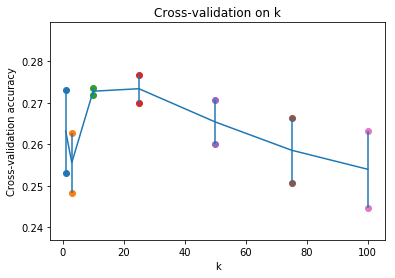

In [12]:
# Plot results
for k in k_choices:
    accuracies = k_to_accuracies[k]
    plt.scatter([k] * len(accuracies), accuracies)

# Plot the trend line of the cross-validation
accuracies_mean = np.array([np.mean(v) for k,v in sorted(k_to_accuracies.items())])
accuracies_std = np.array([np.std(v) for k,v in sorted(k_to_accuracies.items())])
plt.errorbar(k_choices, accuracies_mean, yerr=accuracies_std)
plt.title('Cross-validation on k')
plt.xlabel('k')
plt.ylabel('Cross-validation accuracy')
plt.show()

In [13]:
# Based on the cross-validation results above, choose the best value for k,   
# retrain the classifier using all the training data, and test it on the test
# data. You should be able to get above 28% accuracy on the test data.
best_k = 25

classifier = KNearestNeighbor()
classifier.train(X_train, y_train)
y_test_pred = classifier.predict(X_test, k=best_k)

# Compute and display the accuracy
num_correct = np.sum(y_test_pred == y_test)
accuracy = float(num_correct) / num_test
print('Got %d / %d correct => accuracy: %f' % (num_correct, num_test, accuracy))

Got 137 / 500 correct => accuracy: 0.274000


In [14]:
##################################################################################################################
# The accuracy is based on the k-Nearest Neighbor classifier doesn't take into account The Zen Performer         #
# goal, which is basically looking for the emotional value of each content;                                      #
# for instance a commercial flight and a fight flight won't necessarily provide the same type of emotions;       # 
# Meanwhile it is still an easy way to quickly classify data                                                     #
# even though they are biased; but thanks to the RL tool we will be able to reclassifify them                    #
# later during the process.                                                                                      #
##################################################################################################################